# Autoencoders

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets for Fashion-MNIST
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)


100%|██████████| 26421880/26421880 [00:01<00:00, 15039307.98it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275365.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5036800.51it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20662466.02it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# Create training and test dataloaders
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


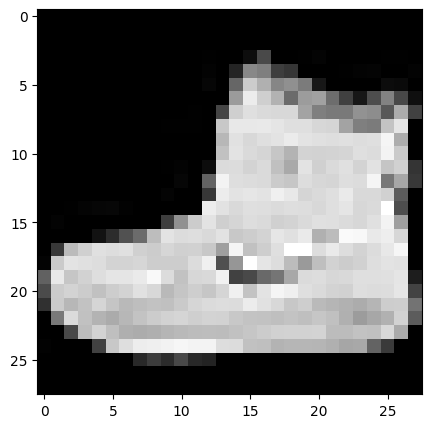

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(iter(train_loader))
images = images.numpy()
# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        
# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [6]:
# specify loss function
criterion = nn.MSELoss()
# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# number of epochs to train the model
n_epochs = 8
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss ))

Epoch: 1 tTraining Loss: 0.439882
Epoch: 2 tTraining Loss: 0.270003
Epoch: 3 tTraining Loss: 0.235199
Epoch: 4 tTraining Loss: 0.218899
Epoch: 5 tTraining Loss: 0.209636
Epoch: 6 tTraining Loss: 0.203738
Epoch: 7 tTraining Loss: 0.199634
Epoch: 8 tTraining Loss: 0.196545


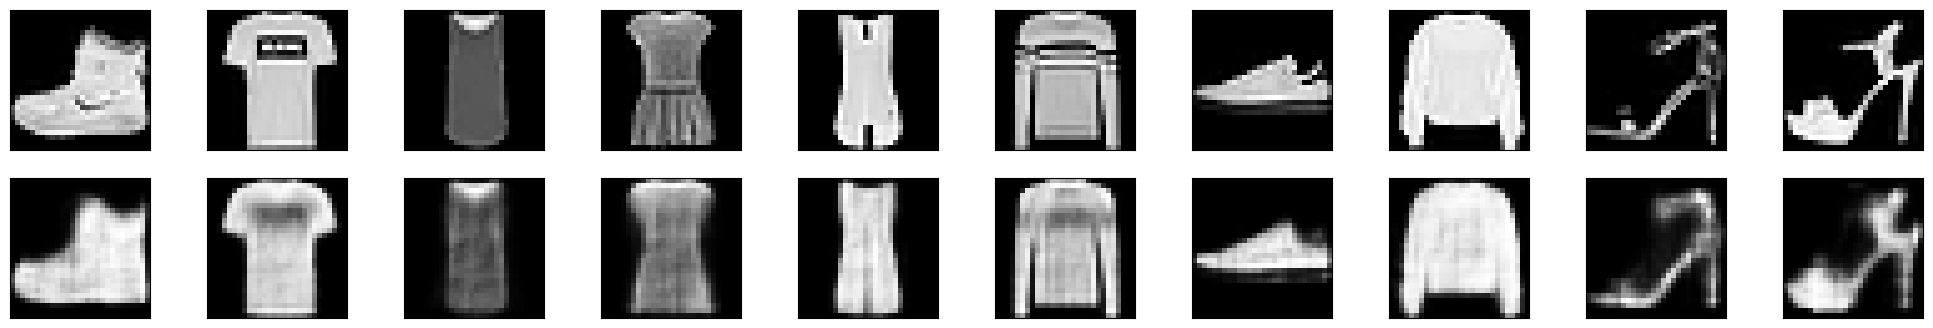

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(iter(train_loader))

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()
# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
# Encode the input data to obtain the latent vector
with torch.no_grad():
    latent_vector = model.encoder(images_flatten)
    print(latent_vector.shape)

torch.Size([20, 32])


## MLP utilizando el vector latente

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the input and output dimensions for your task
input_dim = 32  # Dimensionality of the latent vector
hidden_dim = 64  # Example hidden layer dimension
output_dim = 10  # Example output dimension (number of classes)

# Create an instance of the MLP model
mlp = MLP(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Train the MLP using your labeled data
num_epochs = 10
for epoch in range(num_epochs):
    for data, labels in train_loader:
        optimizer.zero_grad()
        images_flatten = data.view(data.size(0), -1)
        latent_vectors = model.encoder(images_flatten)  # Get latent vectors from autoencoder
        outputs = mlp(latent_vectors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Print epoch number and loss
    print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")



Epoch: 1, Loss: 0.2122
Epoch: 2, Loss: 0.1527
Epoch: 3, Loss: 0.1386
Epoch: 4, Loss: 0.1303
Epoch: 5, Loss: 0.1248
Epoch: 6, Loss: 0.1264
Epoch: 7, Loss: 0.1263
Epoch: 8, Loss: 0.1296
Epoch: 9, Loss: 0.1342
Epoch: 10, Loss: 0.1410


In [12]:
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score


def computeMetrics(y_test, y_pred):
    n_classes = 10
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    
    # Calcular macro AUC
    test_labels_binary = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_one_hot = label_binarize(y_pred, classes=np.unique(y_test))
    n_classes = test_labels_binary.shape[1]
    auc_scores = []
    for i in range(n_classes):
        y_test_i = test_labels_binary[:, i]     
        y_pred_i = y_pred_one_hot[:, i]                 
        auc_i = roc_auc_score(y_test_i, y_pred_i)
        auc_scores.append(auc_i)
    macro_auc = np.mean(auc_scores)

    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred_bin = np.zeros((len(y_test), n_classes))
    y_pred_bin[np.arange(len(y_test)), y_pred] = 1    
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "AUC":macro_auc}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

In [15]:
# Get the latent vector for new data using the autoencoder
with torch.no_grad():
    latent_vector = model.encoder(images_flatten)

# Use the MLP for prediction
predictions = mlp(latent_vector)

# Get the predicted class labels
_, predicted_labels = torch.max(outputs, dim=1)

computeMetrics(labels, predicted_labels)

# Print the predicted class labels
print("\nExpected Labels:")
print(labels.tolist())
print("\nPredicted Labels:")
print(predicted_labels.tolist())


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.9,0.944444,0.888889,0.888889,0.938272



Expected Labels:
[3, 2, 4, 5, 4, 0, 4, 6, 6, 1, 4, 1, 7, 2, 8, 5, 1, 3, 0, 5]

Predicted Labels:
[3, 0, 4, 5, 4, 0, 4, 0, 6, 1, 4, 1, 7, 2, 8, 5, 1, 3, 0, 5]


## MLP sin utilizar el vector latente

In [16]:
# Define the input and output dimensions for your task
input_dim = 784  # Dimensionality of the latent vector
hidden_dim = 64  # Example hidden layer dimension
output_dim = 10  # Example output dimension (number of classes)

# Create an instance of the MLP model
mlp = MLP(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Train the MLP using your labeled data
num_epochs = 10
for epoch in range(num_epochs):
    for data, labels in train_loader:
        optimizer.zero_grad()
        images_flatten = data.view(data.size(0), -1)
        outputs = mlp(images_flatten)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Print epoch number and loss
    print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")



Epoch: 1, Loss: 0.3594
Epoch: 2, Loss: 0.2933
Epoch: 3, Loss: 0.2558
Epoch: 4, Loss: 0.2536
Epoch: 5, Loss: 0.2248
Epoch: 6, Loss: 0.2210
Epoch: 7, Loss: 0.2058
Epoch: 8, Loss: 0.1608
Epoch: 9, Loss: 0.1697
Epoch: 10, Loss: 0.1876


In [17]:
from tabulate import tabulate

# Use the MLP for prediction
predictions = mlp(images_flatten)

# Get the predicted class labels
_, predicted_labels = torch.max(outputs, dim=1)

computeMetrics(labels, predicted_labels)

# Print the predicted class labels
print("\nExpected Labels:")
print(labels.tolist())
print("\nPredicted Labels:")
print(predicted_labels.tolist())

,Accuracy,Precision,Recall,F1 Score,AUC
0,0.85,0.888889,0.861111,0.854497,0.921296



Expected Labels:
[3, 2, 4, 5, 4, 0, 4, 6, 6, 1, 4, 1, 7, 2, 8, 5, 1, 3, 0, 5]

Predicted Labels:
[3, 0, 4, 5, 4, 0, 4, 0, 6, 1, 2, 1, 7, 2, 8, 5, 1, 3, 0, 5]
